In [96]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.units as u
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import forecast
import emcee
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/mcmc_modules')
import unbinned_model as ub
from lnlikelihood import lnLikelihood
import pyccl as ccl
import edit
import h5py, glob
from astropy.coordinates import SkyCoord
from astropy.table import Table
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [98]:
mapping = ub.Mapping()

In [99]:
mapping.set_cosmology(cosmo)

In [100]:
z_grid = np.linspace(.2, 1.2, 500)
logm_grid = np.linspace(14., 15.6, 1020)
fsky_default = 1/2
fsky = fsky_default/3
fsky = 1
theta_aperture = np.arccos(1-2*fsky)*180/np.pi #deg

In [101]:
theta_aperture

180.0

In [102]:
dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
halo_bias_map = mapping.compute_halo_bias_map(z_grid, logm_grid)
sigma2_map = mapping.compute_sigma2_map(z_grid, fsky)

In [103]:
s2 = np.diag(sigma2_map)

In [104]:
sigmab = np.zeros(halo_bias_map.shape)

In [105]:
for i in range(len(logm_grid)):
    sigmab[i,:] = halo_bias_map[i,:] * s2**.5

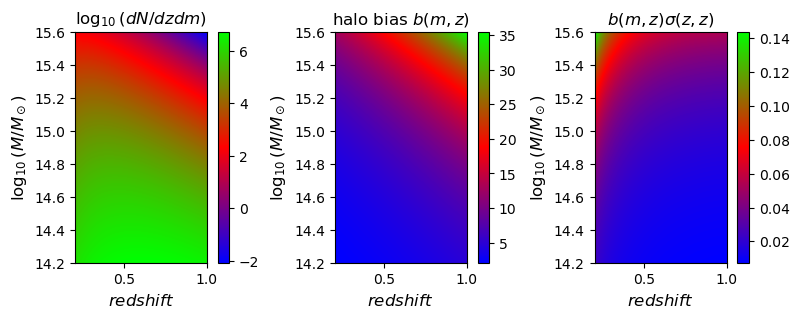

In [106]:
cmap = 'brg'
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.imshow(np.log10(dN_dlogmdz_map/fsky), cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'$\log_{10}(dN/dzdm)$')
plt.colorbar()
plt.xlabel(r'$redshift$', fontsize=12)
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.subplot(132)
plt.imshow(halo_bias_map, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'halo bias $b(m,z)$')
plt.colorbar()
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
plt.subplot(133)
plt.imshow(sigmab*fsky**.5, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'$b(m,z)\sigma(z,z)$')
plt.colorbar()
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
plt.savefig('mapping.png', bbox_inches='tight', dpi=300)

In [107]:
z_corner = np.linspace(.2, 1.2, 6)
log10m_corner = np.linspace(14.2, 15.6, 5)
Z_bin = [[z_corner[i], z_corner[i+1]] for i in range(len(z_corner)-1)]
LogMass_bin = [[log10m_corner[i], log10m_corner[i+1]] for i in range(len(log10m_corner)-1)]

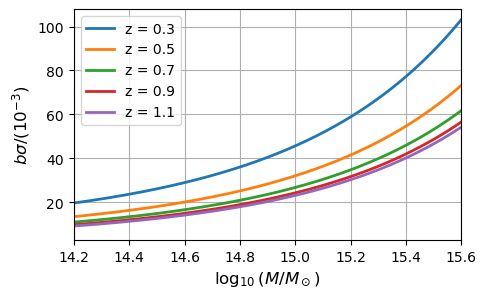

In [108]:
plt.figure(figsize=(5,3))
s = sigmab*fsky**.5
z_index = np.arange(len(z_grid))
for i, z_bin in enumerate(Z_bin):
    mask_z = (z_grid > z_bin[0])*(z_grid < z_bin[1])
    z_index_cut = z_index[mask_z]
    s_cut = s[:,z_index_cut]
    plt.plot(logm_grid, s_cut[:,round(len(z_index_cut)/2)]*1000, 
             label = f'z = {z_grid[z_index_cut[round(len(z_index_cut)/2)]]:.1f}', lw=2)
plt.xlim(14.2, 15.6)
plt.grid()
plt.legend()
plt.ylabel(r'$b\sigma/(10^{-3})$', fontsize=12)
plt.xlabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.savefig('mapping1d_unbinned.png', bbox_inches='tight', dpi=300)

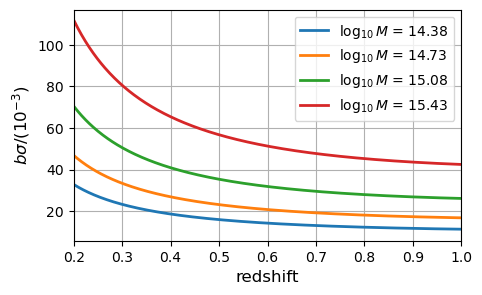

In [109]:
plt.figure(figsize=(5,3))
s = sigmab*fsky**.5
logm_index = np.arange(len(logm_grid))
for i, logm_bin in enumerate(LogMass_bin):
    mask_logm = (logm_grid > logm_bin[0])*(logm_grid < logm_bin[1])
    logm_index_cut = logm_index[mask_logm]
    s_cut = s[logm_index_cut,:]
    plt.plot(z_grid, s_cut[round(len(logm_index_cut)/2),:]*1000, 
             label = r'$\log_{10}M$ = '+f'{logm_grid[logm_index_cut[round(len(logm_index_cut)/2)]]:.2f}', lw=2)
plt.xlim(0.2, 1)
plt.grid()
plt.legend()
plt.ylabel(r'$b\sigma/(10^{-3})$', fontsize=12)
plt.xlabel(r'redshift', fontsize=12)
plt.savefig('mapping1d_unbinned.png', bbox_inches='tight', dpi=300)

In [ ]:
LogMass_bin

In [13]:
mapping.interp(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, )

In [14]:
Nth = mapping.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)

In [15]:
Nth

814934.9235162279

In [16]:
NNSbb_thth = mapping.compute_NNSbb_thth(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, Nth)

In [17]:
NNSbb_thth

549051.3851212972

# Data

In [18]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)
cat_test = pd.read_csv(cat[35] ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
#select in aperture
#ra_center, dec_center = 180, 60
#cat_center_SkyCoord =SkyCoord(ra=np.array([ra_center])*u.degree, dec=np.array([dec_center])*u.degree)
#pos_ra, pos_dec = cat_test['ra'], cat_test['dec']
#cat_pinocchio_SkyCoord=SkyCoord(ra=np.array(pos_ra)*u.degree, dec=np.array(pos_dec)*u.degree)
#idxcat_center, idxcat_pinocchio, d2d, d3d = cat_center_SkyCoord.search_around_sky(cat_pinocchio_SkyCoord, theta_aperture*u.deg)
#resize catalog
#cat_test = Table.from_pandas(cat_test)[idxcat_center]
#raa, decc, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777

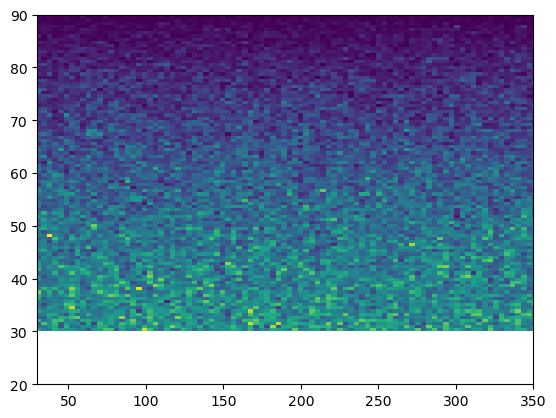

In [19]:
plt.hist2d(ra, dec,bins=100)
#plt.hist2d(raa, decc,bins=100, cmap = 'bwr', cmin=1)
plt.xlim(30, 350)
plt.ylim(20, 90)
plt.show()

In [20]:
mask = (redshift > .2)&(redshift < .3)
mask = mask &(np.log10(Mvir) > 14.3)&(np.log10(Mvir) < 14.4)
redshift_cut = redshift[mask]
Mvir_cut = Mvir[mask]

In [21]:
Nobs = len(Mvir_cut)

In [22]:
Nobs

1638

In [23]:
z_sample = redshift_cut
logm_sample = np.log10(Mvir_cut)

In [24]:
#mapping.create_reduced_sample( z_sample, logm_sample, n_samples =2000)
NNSbb_obsobs = mapping.compute_NNSbb_obsobs(z_grid, logm_grid, 
                                        sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                        z_sample, logm_sample, Nobs, reduced_sample = False)

In [25]:
NNSbb_obsobs

172.4784325519152

In [26]:
#mapping.create_reduced_sample( z_sample, logm_sample, n_samples =5000)
NNSbb_obsth = mapping.compute_NNSbb_obsth(z_grid, logm_grid, 
                                      sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                      z_sample, logm_sample, Nth, Nobs, reduced_sample = False)

In [27]:
NNSbb_obsth 

2741.0451601719506

In [28]:
NSb2_obs = mapping.compute_NSb2_obs(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                            z_sample, logm_sample, Nth, Nobs, reduced_sample = False)

In [29]:
NSb2_obs/2

0.5582918806281936

In [30]:
dN_dzdlogM = mapping.N_map_interp_fct(logm_sample, z_sample, grid = False)

In [31]:
import unbinned_likelihood

ModuleNotFoundError: No module named 'unbinned_likelihood'

In [ ]:
r = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian_SSC(dN_dzdlogM, Nth, Nobs,
                                     NNSbb_obsobs,
                                     NNSbb_obsth,
                                     NNSbb_thth,
                                     NSb2_obs)

In [ ]:
r

In [ ]:
r = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian(dN_dzdlogM, Nth,
                                     )

In [ ]:
r